In [1]:
from datasets import load_dataset
dataset = load_dataset('thainq107/iwslt2015-en-vi')
train_ds = dataset['train']
valid_ds = dataset['validation']
test_ds = dataset['test']

C:\Users\MY PC\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
print(len(train_ds))
print(len(valid_ds))
print(len(test_ds))

133317
1268
1268


In [16]:
import random
indices = random.sample(range(len(train_ds)), 5)
for idx in indices:
    example = train_ds[idx]
    print(f"Example {idx}:")
    print("EN:", example["en"])
    print("VI:", example["vi"])
    print("-" * 50)

Example 107084:
EN: Al Jazeera is not a tool of revolution .
VI: Al Jazeera không phải là một công cụ của cách mạng .
--------------------------------------------------
Example 86907:
EN: And he said , &quot; Well , recently I pitched a sustainability project to a client , and turned and he said to me , &apos; I know it &apos;s going to cost less , I know it &apos;s going to sell more , but we &apos;re not pioneers , because pioneers have arrows in their backs . &apos; &quot; I think we &apos;ve got a roomful of pioneers , and I hope there are far more pioneers out there , because we need to solve these problems .
VI: Anh ấy đáp : &quot; À , mới đây tôi trình bày một dự án &quot; bền vững &quot; cho khách hàng , Vị khách hàng nói rằng &quot; Tôi biết phương án này của anh ít tốn chi phí hơn chắc sẽ bán được nhiều hơn nhưng tôi chẳng dại gì làm người tiên phong , bởi vì muốn làm người tiên phong thì phải có động lực Tôi nghĩ rằng trong phòng này ai cũng là người tiên phong Tôi cũng hy v

In [2]:
import html
import re
import unicodedata
def preprocess_text(text: str) -> str:
    text = html.unescape(text)
    text = text.lower()
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_example(example):
    example['en'] = preprocess_text(example['en'])
    example['vi'] = preprocess_text(example['vi'])
    return example

train_ds = train_ds.map(preprocess_example)

In [18]:
for idx in indices:
    example = train_ds[idx]
    print(f"Example {idx}:")
    print("EN:", example["en"])
    print("VI:", example["vi"])
    print("-" * 50)

Example 107084:
EN: al jazeera is not a tool of revolution .
VI: al jazeera không phải là một công cụ của cách mạng .
--------------------------------------------------
Example 86907:
EN: and he said , " well , recently i pitched a sustainability project to a client , and turned and he said to me , ' i know it 's going to cost less , i know it 's going to sell more , but we 're not pioneers , because pioneers have arrows in their backs . ' " i think we 've got a roomful of pioneers , and i hope there are far more pioneers out there , because we need to solve these problems .
VI: anh ấy đáp : " à , mới đây tôi trình bày một dự án " bền vững " cho khách hàng , vị khách hàng nói rằng " tôi biết phương án này của anh ít tốn chi phí hơn chắc sẽ bán được nhiều hơn nhưng tôi chẳng dại gì làm người tiên phong , bởi vì muốn làm người tiên phong thì phải có động lực tôi nghĩ rằng trong phòng này ai cũng là người tiên phong tôi cũng hy vọng ngày càng có thêm nhiều người tiên phong
---------------

In [5]:
engs = train_ds['en']
unique_engs = set(engs)
len(engs)

133317

In [6]:
vis = train_ds['vi']
unique_vis = set(vis)
len(vis)

133317

# Tune vocab_size with unigram model

EN = 12000

MAX_LEN_EN = 150

VI = 7000

MAX_LEN_VI = 180

In [3]:
import sentencepiece as spm
import os
VOCAB_MODEL_TYPE = 'unigram'

In [8]:
from collections import Counter
VOCAB_SIZES = [16000, 17000, 18000, 19000, 20000]
with open('temp_train.en', 'w', encoding='utf-8') as f:
    for x in unique_engs:
        f.write(x.strip() + '\n')
for vs in VOCAB_SIZES:
    spm.SentencePieceTrainer.train(
        input='temp_train.en',
        model_prefix='spm_en',
        vocab_size=vs,
        model_type=VOCAB_MODEL_TYPE,
        character_coverage=1.0,
        pad_id=0,
        bos_id=1,
        eos_id=2,
        unk_id=3
    )
    sp = spm.SentencePieceProcessor(model_file=f"spm_en.model")
    token_counts = Counter()
    for sent in unique_engs:
        tokens = sp.encode(sent)
        token_counts.update(tokens)
    num_rare_token = sum(1 for t, c in token_counts.items() if c < 2)
    print(f'Vocab size {vs}: {num_rare_token} rare tokens')
    os.remove('spm_en.model')
    os.remove('spm_en.vocab')
os.remove("temp_train.en")

Vocab size 16000: 21 rare tokens
Vocab size 17000: 33 rare tokens
Vocab size 18000: 85 rare tokens
Vocab size 19000: 121 rare tokens
Vocab size 20000: 520 rare tokens


In [10]:
VOCAB_SIZES = [10000, 10500, 11000, 11500, 12000]
with open('temp_train.vi', 'w', encoding='utf-8') as f:
    for x in unique_vis:
        f.write(x.strip() + '\n')
for vs in VOCAB_SIZES:
    spm.SentencePieceTrainer.train(
        input='temp_train.vi',
        model_prefix='spm_vi',
        vocab_size=vs,
        model_type=VOCAB_MODEL_TYPE,
        character_coverage=0.9995,
        pad_id=0,
        bos_id=1,
        eos_id=2,
        unk_id=3
    )
    sp = spm.SentencePieceProcessor(model_file=f"spm_vi.model")
    token_counts = Counter()
    for sent in unique_vis:
        tokens = sp.encode(sent)
        token_counts.update(tokens)
    num_rare_token = sum(1 for t, c in token_counts.items() if c < 2)
    print(f'Vocab size {vs}: {num_rare_token} rare tokens')
    os.remove('spm_vi.model')
    os.remove('spm_vi.vocab')
os.remove("temp_train.vi")

Vocab size 10000: 57 rare tokens
Vocab size 10500: 267 rare tokens
Vocab size 11000: 659 rare tokens
Vocab size 11500: 1109 rare tokens
Vocab size 12000: 1644 rare tokens


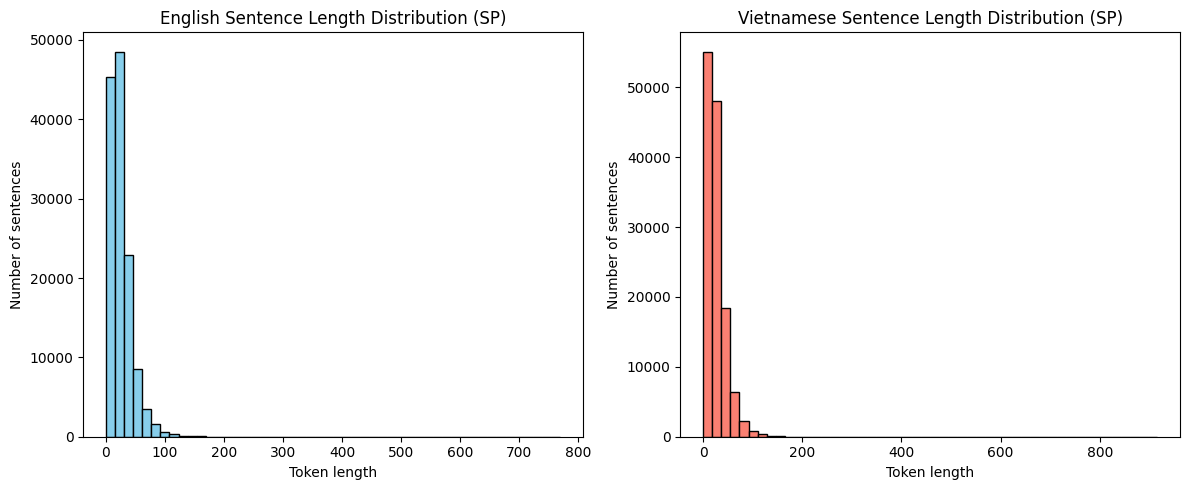

In [11]:
VOCAB_SIZE_EN = 18000
VOCAB_SIZE_VI = 10500

with open('temp_train.en', 'w', encoding='utf-8') as f:
    for x in unique_engs:
        f.write(x.strip() + '\n')
spm.SentencePieceTrainer.train(
    input='temp_train.en',
    model_prefix='spm_en',
    vocab_size=VOCAB_SIZE_EN,
    model_type=VOCAB_MODEL_TYPE,
    character_coverage=1.0,
    pad_id=0,
    bos_id=1,
    eos_id=2,
    unk_id=3
)
with open('temp_train.vi', 'w', encoding='utf-8') as f:
    for x in unique_vis:
        f.write(x.strip() + '\n')
spm.SentencePieceTrainer.train(
    input='temp_train.vi',
    model_prefix='spm_vi',
    vocab_size=VOCAB_SIZE_VI,
    model_type=VOCAB_MODEL_TYPE,
    character_coverage=1.0,
    pad_id=0,
    bos_id=1,
    eos_id=2,
    unk_id=3
)

en_sp = spm.SentencePieceProcessor(model_file=f"spm_en.model")
vi_sp = spm.SentencePieceProcessor(model_file=f"spm_vi.model")

import matplotlib.pyplot as plt

en_lengths = [len(en_sp.encode(sent)) for sent in unique_engs]
vi_lengths = [len(vi_sp.encode(sent)) for sent in unique_vis]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(en_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("English Sentence Length Distribution (SP)")
plt.xlabel("Token length")
plt.ylabel("Number of sentences")

plt.subplot(1,2,2)
plt.hist(vi_lengths, bins=50, color='salmon', edgecolor='black')
plt.title("Vietnamese Sentence Length Distribution (SP)")
plt.xlabel("Token length")
plt.ylabel("Number of sentences")

plt.tight_layout()
plt.show()

os.remove('spm_en.model')
os.remove('spm_en.vocab')
os.remove('spm_vi.model')
os.remove('spm_vi.vocab')
os.remove("temp_train.en")
os.remove("temp_train.vi")